# Interpretability of heartbeat classification using a CNN model and Class Activation Maps

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from itertools import islice
from sklearn.preprocessing import normalize
sns.set()

length = 277

### Extract task-specific data and one-hot encode labels

In [4]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data, and one-hot encode Y:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_train.shape[1], 1)

y_train = train_values[:,-2]
y_test = test_values[:,-2]

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

Loading  ../../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


In [5]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

verbose, epoch, batch_size = 1, 10, 64
activationFunction='relu'

def getModel(): 
    cnnmodel = Sequential()
    cnnmodel.add(Conv1D(filters=128, kernel_size=16,padding='same', activation='relu',input_shape=(X_train.shape[1], X_train.shape[2])))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=32, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Conv1D(filters=9, kernel_size=16,padding='same', activation='relu'))
    cnnmodel.add(GlobalAveragePooling1D())
    cnnmodel.add(Dense(9, activation='softmax'))
    cnnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    cnnmodel.summary()
    return cnnmodel

cnnmodel = getModel()
cnnhistory= cnnmodel.fit(X_train, y_train, epochs=epoch, verbose=verbose, validation_split=0.2, batch_size = batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 275, 128)          2176      
_________________________________________________________________
batch_normalization (BatchNo (None, 275, 128)          512       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 275, 32)           65568     
_________________________________________________________________
batch_normalization_1 (Batch (None, 275, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 275, 9)            4617      
_________________________________________________________________
global_average_pooling1d (Gl (None, 9)                 0         
__________________________________________________

C:\Program Files\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


25529/25529 [==============================] - 36s 1ms/sample - loss: 1.1145 - accuracy: 0.6276 - val_loss: 1.3831 - val_accuracy: 0.4990
Epoch 2/10
25529/25529 [==============================] - 38s 1ms/sample - loss: 0.4577 - accuracy: 0.8517 - val_loss: 0.4985 - val_accuracy: 0.8161
Epoch 3/10
25529/25529 [==============================] - 38s 1ms/sample - loss: 0.3491 - accuracy: 0.8822 - val_loss: 0.4546 - val_accuracy: 0.8429
Epoch 4/10
25529/25529 [==============================] - 38s 1ms/sample - loss: 0.3010 - accuracy: 0.8965 - val_loss: 0.3242 - val_accuracy: 0.8874
Epoch 5/10
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.2797 - accuracy: 0.9042 - val_loss: 0.4022 - val_accuracy: 0.8637
Epoch 6/10
25529/25529 [==============================] - 38s 1ms/sample - loss: 0.2493 - accuracy: 0.9142 - val_loss: 0.2897 - val_accuracy: 0.9018
Epoch 7/10
25529/25529 [==============================] - 37s 1ms/sample - loss: 0.2326 - accuracy: 0.9200 - val_loss

In [116]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(cnnmodel, 'cnnmodel_cam_ecg.h5')

### Choose a class to get the class activation maps for

In [67]:
# Get all the data that corresponds to one single class (class 8 / 'I'):
class_num = 8
class_ann = 'I'

N_test = test_values[test_values[:,-2]==class_num]

X_test = N_test[:,:-2]
y_test = N_test[:len(N_test),-2]

X_test1 = X_test.reshape(-1, X_test.shape[1], 1)
y_test1 = to_categorical(y_test)
cnnpredictions = cnnmodel.predict(X_test1)

### Create a performance metrics function

In [68]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Call the performance metrics function per class

C:\Program Files\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-69-42e0dbbe1108>:8: RuntimeWarning: invalid value encountered in true_divide
  CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]


Accuracy  : 0.9879518072289156
Precision : 0.2
Recall : 0.19759036144578312
f1score : 0.1987878787878788


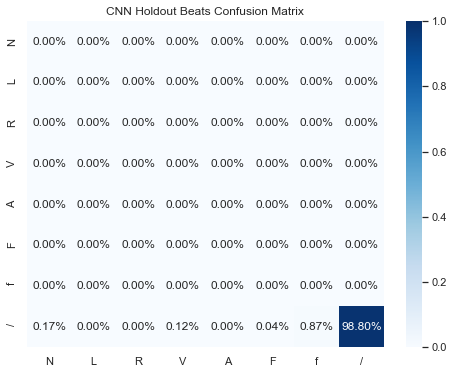

In [69]:
cnn_predict=np.argmax(cnnpredictions,axis=1)
cnn_actual_value=np.argmax(y_test1,axis=1)
cnn_results = showResults(cnn_actual_value, cnn_predict,'CNN')

# Plot confusion matrix:
categories=['N','L','R','V','A','F','f','/']
fig = plt.figure(figsize=(8,6))
CNN_cf_m = cnn_results[5].astype('float')/ cnn_results[5].sum(axis=1)[:,np.newaxis]
sns.heatmap(np.nan_to_num(CNN_cf_m),annot=True,fmt='.2%',xticklabels=categories,yticklabels=categories,vmin=0,vmax=1,cmap='Blues')
plt.title('CNN Holdout Beats Confusion Matrix')
plt.show()
fig.savefig('cm.jpg', dpi = 400)

### Get class activation maps and the predictions

In [70]:
# Max number of instances:
num_inst = 10000

# Get the features / last convolutional layer:
get_last_conv1 = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[4].output])
last_conv1_cnn = get_last_conv1([X_test1[:num_inst]])[0]

# Get the output probabilities:
get_softmax1_cnn = keras.backend.function([cnnmodel.layers[0].input, keras.backend.learning_phase()], [cnnmodel.layers[-1].output])
softmax1_cnn = get_softmax1_cnn(([X_test1[:num_inst]]))[0]

# Get the weights of the pooling/softmax layer:
softmax_weight_cnn = cnnmodel.get_weights()[-1]

# Compute the Class Activation Map and normalize:
CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)
CAM = np.abs(CAM)
CAM_norm = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))

### Visualize CAM results with saliency maps for the correctly classified beats

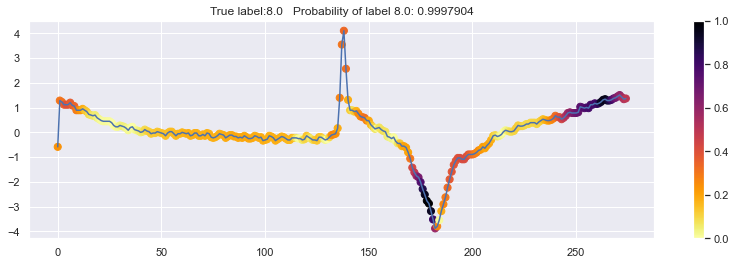

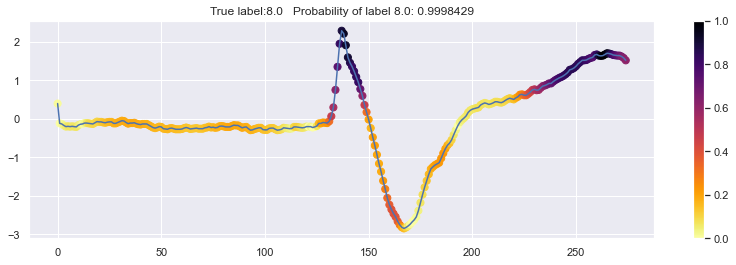

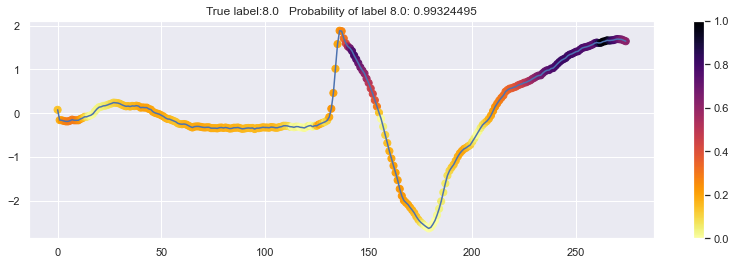

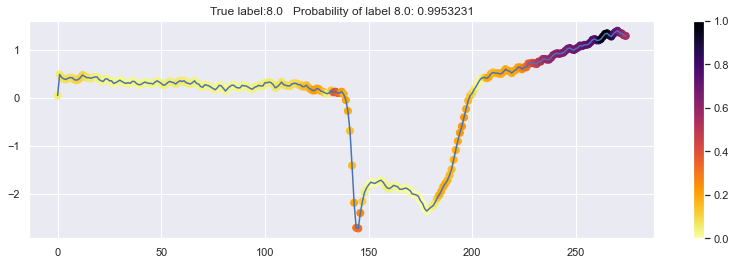

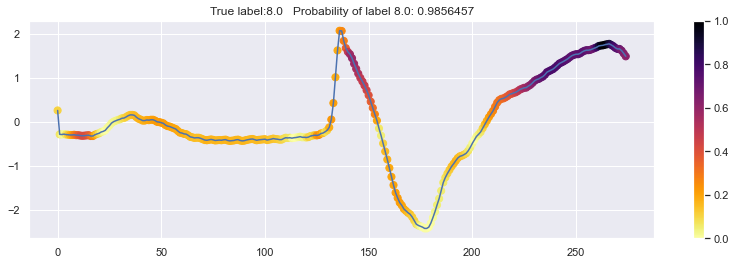

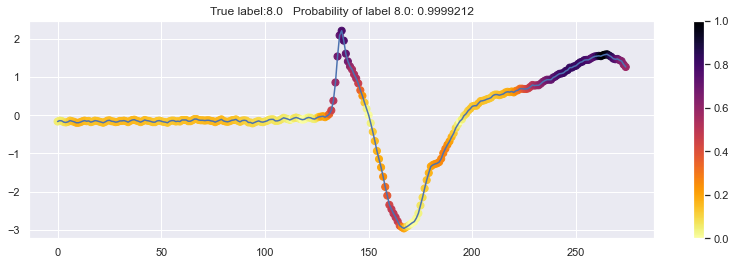

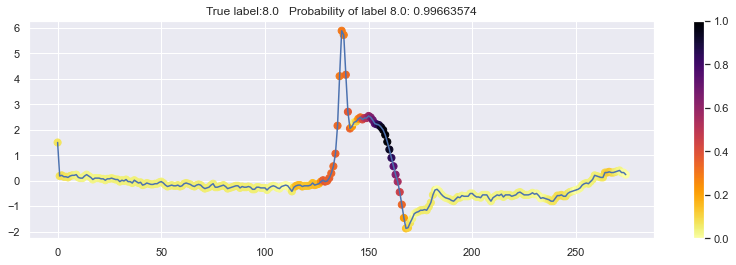

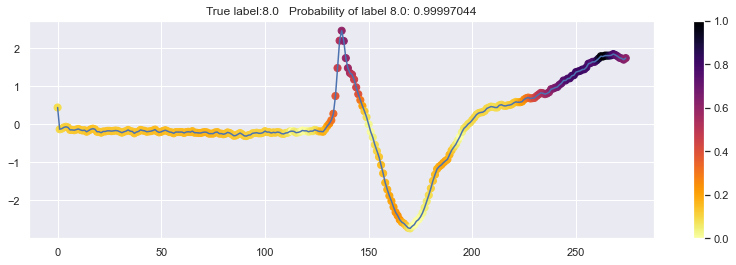

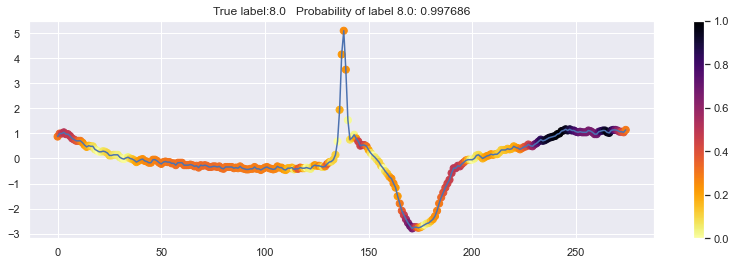

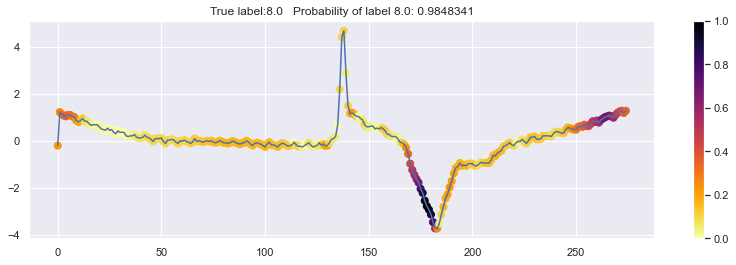

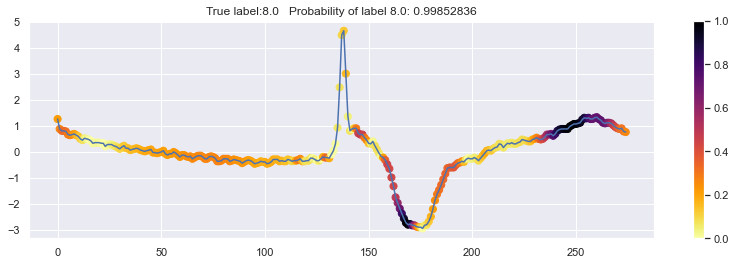

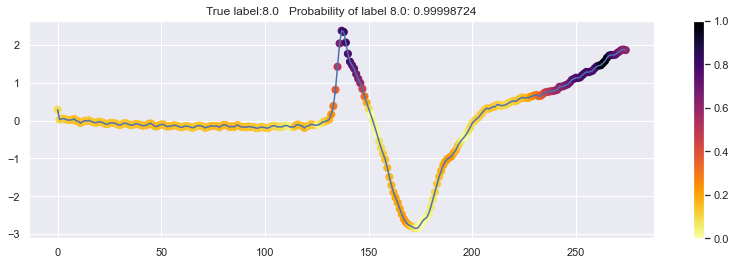

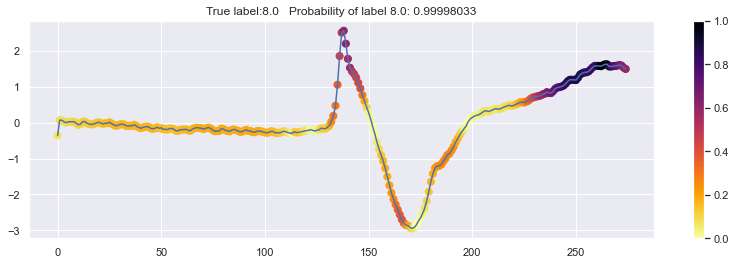

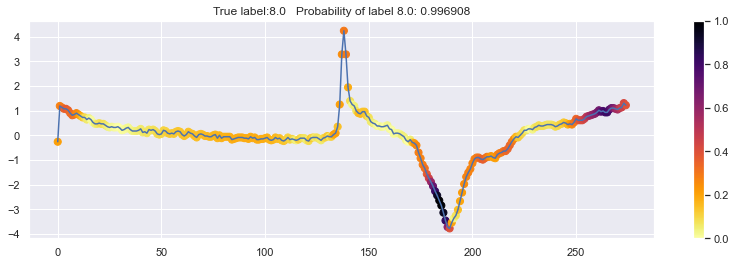

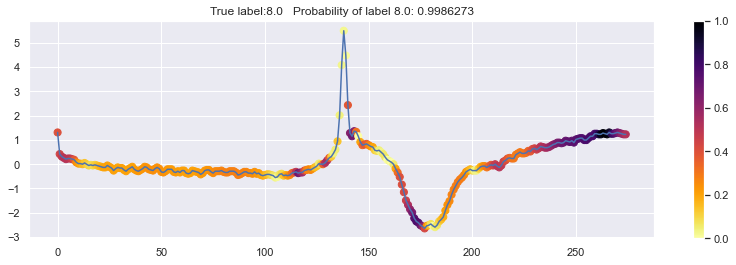

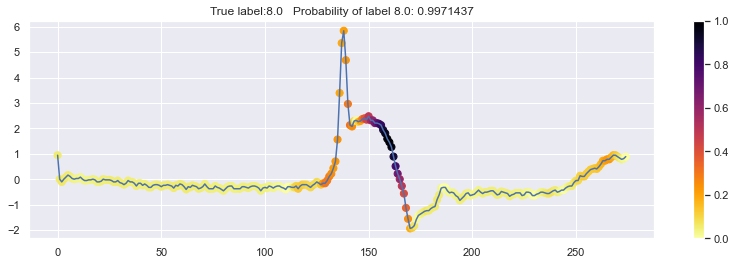

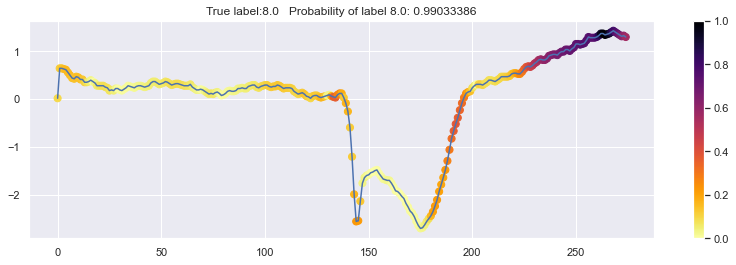

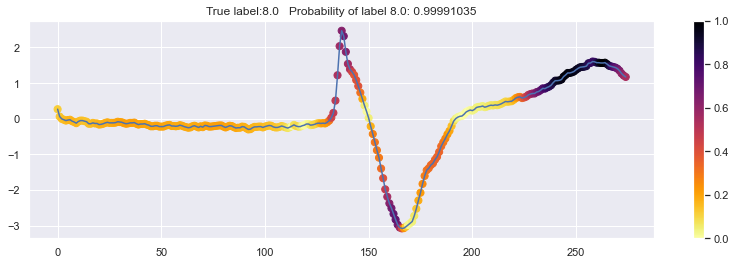

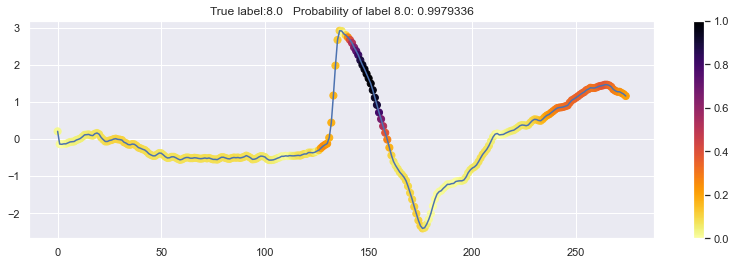

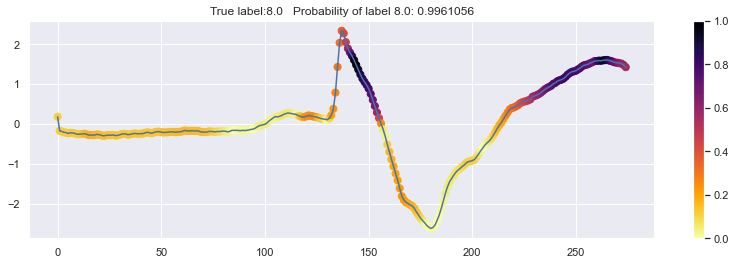

In [71]:
# Get the corectly classified data:
correct_cnn = np.where(cnn_predict == cnn_actual_value)
correct_cnn = correct_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in correct_cnn[20:40]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=CAM_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
    clim= np.ravel(CAM_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Visualize CAM results with saliency maps for the heartbeats that were not correctly classified

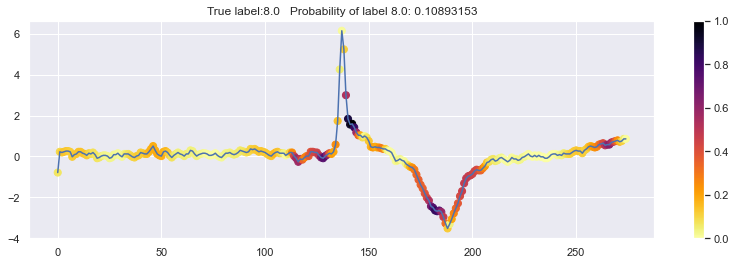

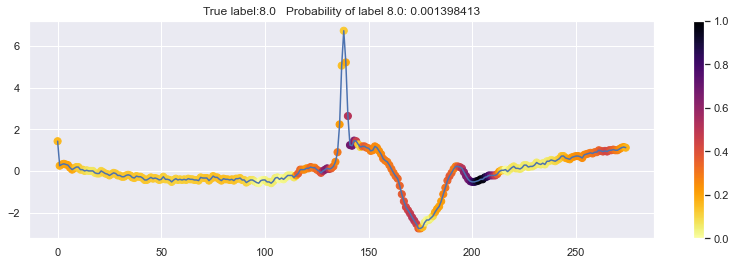

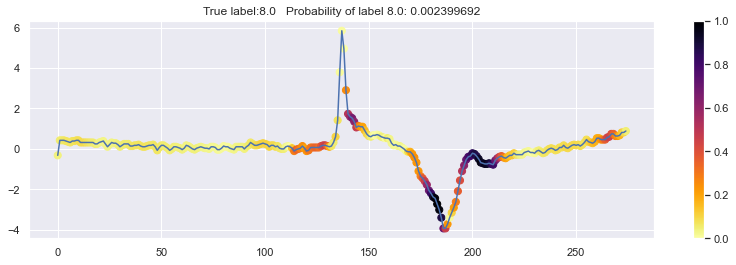

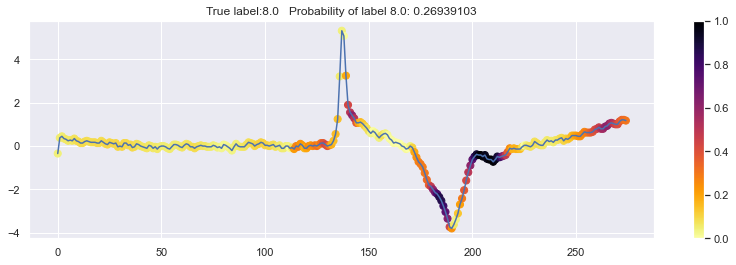

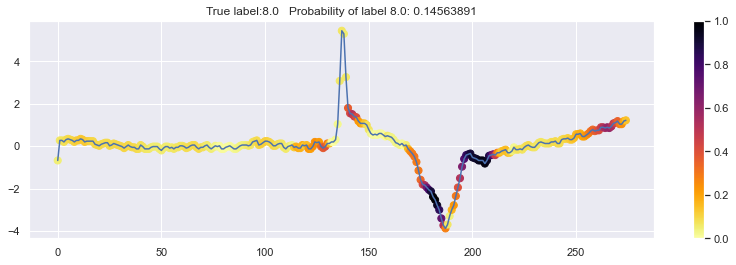

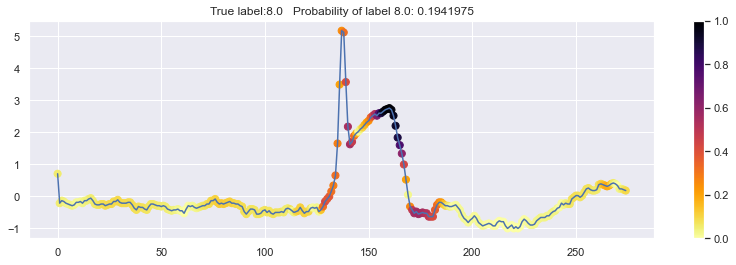

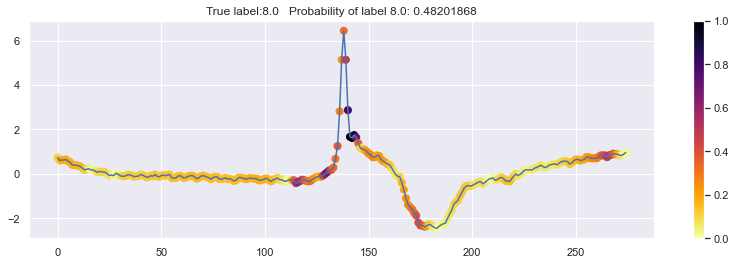

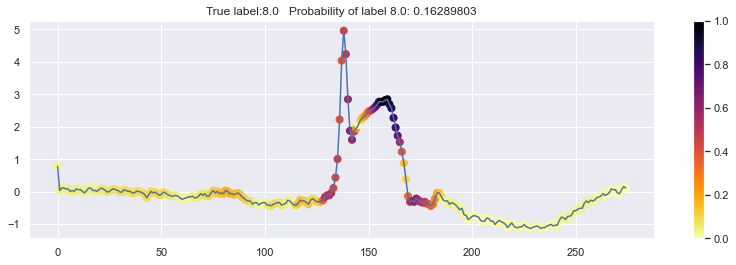

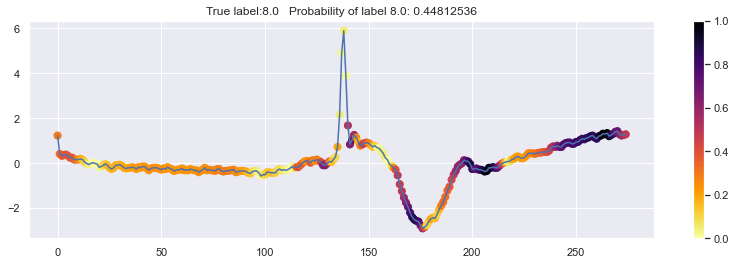

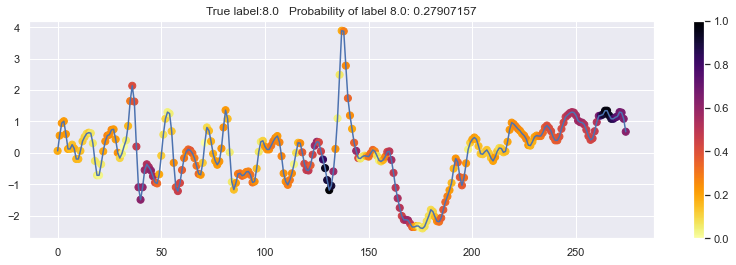

In [72]:
# Get the misclassified data:
misclass_cnn = np.where(cnn_predict!=cnn_actual_value)
misclass_cnn = misclass_cnn[0].tolist()

# Plot a few examples of heatmaps:
for i in misclass_cnn[:10]:
    plt.figure(figsize=(14, 4))
    plt.plot(X_test1[i].squeeze())
    plt.scatter(np.arange(len(X_test1[i])), X_test1[i].squeeze(), cmap='inferno_r', c=CAM_norm[i,:].squeeze(), s=50)
    plt.title('True label:' + str(y_test[i]) + '   Probability of label ' + str(y_test[i]) + ': ' + str(softmax1_cnn[i][int(y_test[i])]))
    clim= np.ravel(CAM_norm)
    plt.clim(min(clim),max(clim))
    plt.colorbar()
    plt.show

### Divide the  ECG beats into 11 segments and compute the class activation maps per segment

In [73]:
# Means of slice function:
def means_of_slices(iterable, slice_size):
    iterator = iter(iterable)
    while True:
        slice = list(islice(iterator, slice_size))
        if slice:
            yield np.sum(slice)/len(slice)
        else:
            return

# Compute the class activation maps:
CAM = np.dot(last_conv1_cnn, softmax_weight_cnn)
CAM = np.abs(CAM)
a = (CAM - CAM.min(axis=1, keepdims=True)) / (CAM.max(axis=1, keepdims=True) - CAM.min(axis=1, keepdims=True))

# Divide the result into slices:
cam_per_segment = []
for i in range(len(last_conv1_cnn)):
    means = list(means_of_slices(a[i], 25))
    cam_per_segment.append(means)
cam_per_segment = np.array(cam_per_segment)

# Repeat the values 25 times for visualization purposes:
cam_per_segment_repeat = []
for i in cam_per_segment:
    cam_per_segment_repeat.append(np.repeat(i,25))
cam_per_segment_repeat = np.array(cam_per_segment_repeat)

### Plot the average class activation maps per segment on a sample ECG beat

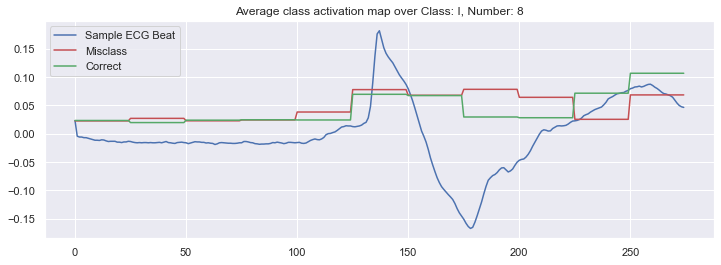

In [75]:
# Normalize correct and incorrect predictions:
ecg_correct_norm = normalize(cam_per_segment_repeat[correct_cnn[:1000]])
ecg_incorrect_norm = normalize(cam_per_segment_repeat[misclass_cnn[:10]])

# Normalize ECG heartbeat example:
ecg_norm = normalize(X_test1[:,:,0])

# Take means of all correct and incorrect segments:
mean_correct = ecg_correct_norm.mean(axis=0)
mean_incorrect = ecg_incorrect_norm.mean(axis=0)

# Visualize:
plt.figure(figsize=(12,4))
plt.plot(ecg_norm[0],color='b',label='Sample ECG Beat')
plt.plot(np.abs(mean_incorrect), color='r', label='Misclass')
plt.plot(np.abs(mean_correct), color='g', label='Correct')
plt.title('Average class activation map over '+'Class: ' + class_ann +', Number: ' + str(class_num))
plt.legend()
plt.savefig(fname='cnn_cam_' + class_ann + '.png', bbox_inches='tight', dpi=400)
plt.show()